# Titanic Disaster

## Author: Nicolas Hernandez Zapata

### Description
Use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

Model Exploration

In [1]:
import numpy as np 
import pandas as pd 
from catboost import CatBoostClassifier, Pool
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


#### CatboostClassifier

CatBoostClassifier is a machine learning algorithm based on gradient boosting over decision trees, specifically optimized for categorical features. It is known for its ease of use, high performance, and unique handling of categorical data without requiring extensive preprocessing.

* CatBoost builds an ensemble of decision trees sequentially. Each tree attempts to correct the errors of the previous trees by minimizing a loss function.
* CatBoost uses symmetric decision trees, where all splits at the same depth level are the same across all branches. This structure reduces overfitting and speeds up prediction times.
* CatBoost uses ordered boosting, which involves creating random permutations of the data and training each decision tree on only the data points seen before the current observation in the permutation, reducing overfitting and improving model robustness
##### When to use
* Datasets with Many Categorical Features
* To get fast training times

In [2]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
train_cat = train[["Survived", "Pclass", "Sex", "Embarked"]].copy()
#Embarked has 2 missing values so let's drop them
train_cat.dropna(inplace = True)
print("Lenght train_cat:", len(train_cat))
X_cat = train_cat.drop('Survived', axis=1)
y_cat = train_cat['Survived']
X_train, X_temp, y_train, y_temp = train_test_split(X_cat, y_cat, test_size=0.3, random_state=42) #Separate train set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) #Create validation and test set

Lenght train_cat: 889


In [3]:
cat_features =["Sex", "Embarked"]
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)
#Pool is a data container that contains the training dataset, 
#along with optionally the target variable and details about the categorical features
cat_model = CatBoostClassifier(eval_metric='Accuracy',
                               random_seed=42,
                               cat_features=cat_features,
                               verbose=10,
                               early_stopping_rounds=50
                              )
cat_model.fit(train_pool, eval_set=val_pool, verbose=True)

Learning rate set to 0.028182
0:	learn: 0.7845659	test: 0.7819549	best: 0.7819549 (0)	total: 54.1ms	remaining: 54.1s
1:	learn: 0.7845659	test: 0.7819549	best: 0.7819549 (0)	total: 56.3ms	remaining: 28.1s
2:	learn: 0.7845659	test: 0.7819549	best: 0.7819549 (0)	total: 57.8ms	remaining: 19.2s
3:	learn: 0.7845659	test: 0.7819549	best: 0.7819549 (0)	total: 59.2ms	remaining: 14.7s
4:	learn: 0.7845659	test: 0.7819549	best: 0.7819549 (0)	total: 60.9ms	remaining: 12.1s
5:	learn: 0.8135048	test: 0.8120301	best: 0.8120301 (5)	total: 62.9ms	remaining: 10.4s
6:	learn: 0.8135048	test: 0.8120301	best: 0.8120301 (5)	total: 64.5ms	remaining: 9.15s
7:	learn: 0.8135048	test: 0.8120301	best: 0.8120301 (5)	total: 66ms	remaining: 8.19s
8:	learn: 0.8135048	test: 0.8120301	best: 0.8120301 (5)	total: 67.3ms	remaining: 7.42s
9:	learn: 0.8135048	test: 0.8120301	best: 0.8120301 (5)	total: 68.4ms	remaining: 6.78s
10:	learn: 0.8135048	test: 0.8120301	best: 0.8120301 (5)	total: 69.7ms	remaining: 6.27s
11:	learn: 0.8

In [4]:
y_pred = cat_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85        81
           1       0.86      0.58      0.70        53

    accuracy                           0.80       134
   macro avg       0.82      0.76      0.77       134
weighted avg       0.81      0.80      0.79       134



In [5]:
feature_importance  = cat_model.get_feature_importance(prettified=True)
print(feature_importance)

  Feature Id  Importances
0        Sex    72.027809
1     Pclass    25.946013
2   Embarked     2.026178


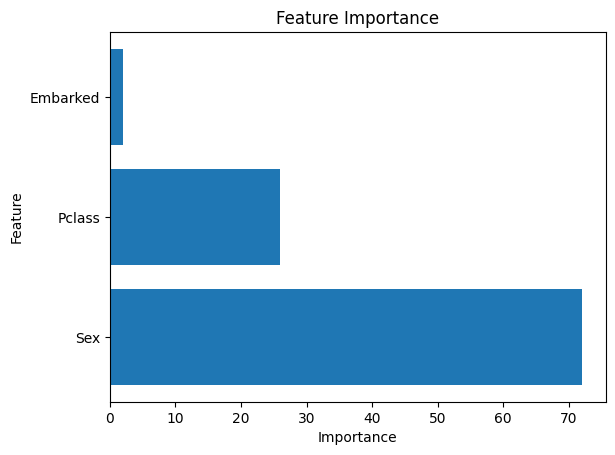

In [6]:
plt.barh(feature_importance['Feature Id'], feature_importance['Importances'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

From this attempt we can conclude that the embarked feature is not relevant to the model. On the contrary Pclass shows some relevance in the decision making. In the next models we won't include the embarked feature.

#### CatBoostModel

In this model all variables will be taken into account. We won´t include the embarked feature due to it's lack of relevance. Age won't be included due to the missing values.

In [7]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
train_cat_2 = train[["Survived", "Pclass", "Sex", "SibSp", "Parch", "Fare"]].copy()
print("Lenght train_cat:", len(train_cat_2))
X_cat_2 = train_cat_2.drop('Survived', axis=1)
y_cat_2 = train_cat_2['Survived']
X_train_cat_2, X_temp_cat_2, y_train_cat_2, y_temp_cat_2 = train_test_split(X_cat_2, y_cat_2, test_size=0.3, random_state=42) #Separate train set
X_val_cat_2, X_test_cat_2, y_val_cat_2, y_test_cat_2 = train_test_split(X_temp_cat_2, y_temp_cat_2, test_size=0.5, random_state=42) #Create validation and test set

Lenght train_cat: 891


In [8]:
cat_features =["Sex"]
train_pool_cat_2 = Pool(data=X_train_cat_2, label=y_train_cat_2, cat_features=cat_features)
val_pool_cat_2 = Pool(data=X_val_cat_2, label=y_val_cat_2, cat_features=cat_features)
#Pool is a data container that contains the training dataset, 
#along with optionally the target variable and details about the categorical features
cat_model_2 = CatBoostClassifier(eval_metric='Accuracy',
                               random_seed=42,
                               cat_features=cat_features,
                               verbose=50,
                               early_stopping_rounds=50
                              )
cat_model_2.fit(train_pool_cat_2, eval_set=val_pool_cat_2, verbose=True)

Learning rate set to 0.028193
0:	learn: 0.7849117	test: 0.8059701	best: 0.8059701 (0)	total: 916us	remaining: 916ms
1:	learn: 0.8041734	test: 0.8208955	best: 0.8208955 (1)	total: 2.22ms	remaining: 1.11s
2:	learn: 0.8073836	test: 0.8283582	best: 0.8283582 (2)	total: 3.31ms	remaining: 1.1s
3:	learn: 0.8073836	test: 0.8283582	best: 0.8283582 (2)	total: 4.1ms	remaining: 1.02s
4:	learn: 0.8073836	test: 0.8283582	best: 0.8283582 (2)	total: 5.16ms	remaining: 1.03s
5:	learn: 0.8089888	test: 0.8208955	best: 0.8283582 (2)	total: 6.27ms	remaining: 1.04s
6:	learn: 0.8057785	test: 0.8208955	best: 0.8283582 (2)	total: 7.38ms	remaining: 1.05s
7:	learn: 0.8057785	test: 0.8208955	best: 0.8283582 (2)	total: 8.49ms	remaining: 1.05s
8:	learn: 0.8105939	test: 0.8208955	best: 0.8283582 (2)	total: 9.58ms	remaining: 1.05s
9:	learn: 0.8121990	test: 0.8208955	best: 0.8283582 (2)	total: 10.4ms	remaining: 1.03s
10:	learn: 0.8121990	test: 0.8208955	best: 0.8283582 (2)	total: 11.5ms	remaining: 1.03s
11:	learn: 0.81

In [9]:
y_pred_cat_2 = cat_model_2.predict(X_test_cat_2)
print(classification_report(y_test_cat_2, y_pred_cat_2))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85        87
           1       0.74      0.66      0.70        47

    accuracy                           0.80       134
   macro avg       0.78      0.77      0.77       134
weighted avg       0.80      0.80      0.80       134



  Feature Id  Importances
0        Sex    73.839235
1     Pclass    20.981651
2       Fare     1.797719
3      SibSp     1.755459
4      Parch     1.625936


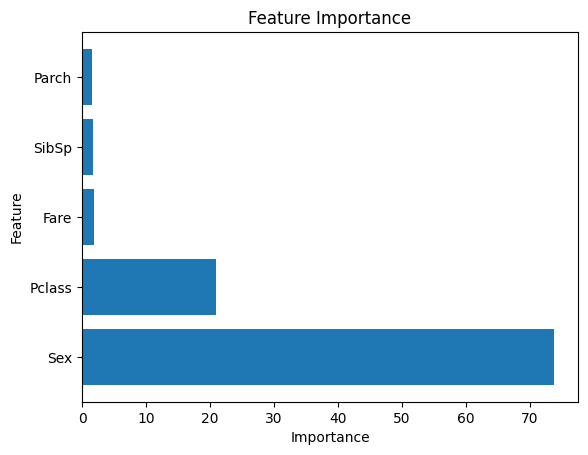

In [10]:
feature_importance  = cat_model_2.get_feature_importance(prettified=True)
print(feature_importance)

plt.barh(feature_importance['Feature Id'], feature_importance['Importances'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

The results improve in the validation set, but in the test set, the results were the same in terms of accuracy.

As the previous model, Sex and Pclass are the most important features. The rest of the features are not relevant and as the results don't change in a significant way it's possible to remove them.

In the next model the age will be added in two ways, removing the missing fields and imputating the missing fields.

Tiempo estimado hasta aquí: ~1 hour